In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [2]:
from gcimpute.gaussian_copula import GaussianCopula
from gcimpute.low_rank_gaussian_copula import LowRankGaussianCopula
from gcimpute.helper_data import load_GSS, load_movielens1m, load_FRED, load_whitewine
from gcimpute.helper_mask import mask_MCAR
from gcimpute.helper_evaluation import get_smae, get_mae

Two versions of **gcimpute** are available: one as a Python package available from PyPI, and the other as a R package (https://github.com/udellgroup/mixedgcImp). Both versions use the same algorithms and have the same functionality. Here we demonstrates how to use the Python version.

## Basic usage

To demonstrate the basis usage of **gcimpute**, we use demographic data from the 2014 General Social Survey (GSS) data: we consider the variables age (`AGE`), highest degree (`DEGREE`), income (`RINCOME`), subjective class identification (`CLASS`), satisfaction with the work (`SATJOB`), weeks worked last year (`WEEKSWRK`), general happiness (`HAPPY`), and condition of health (`HEALTH`). All variables are ordinal variables encoded as integers, with varying number of ordinal categories. 
The integers could represent numbers, such as $0, 1, \cdots, 52$ for `WEEKSWRK`, or ordered categories, such as 1 (Very happy), 2 (Pretty happy), 3 (Not too happy) for the question: how would you say things are these days (`HAPPY`).  Many missing entries appear due to answers like Don't know, No answer, Not applicable, etc. Variable histograms are plotted in below:

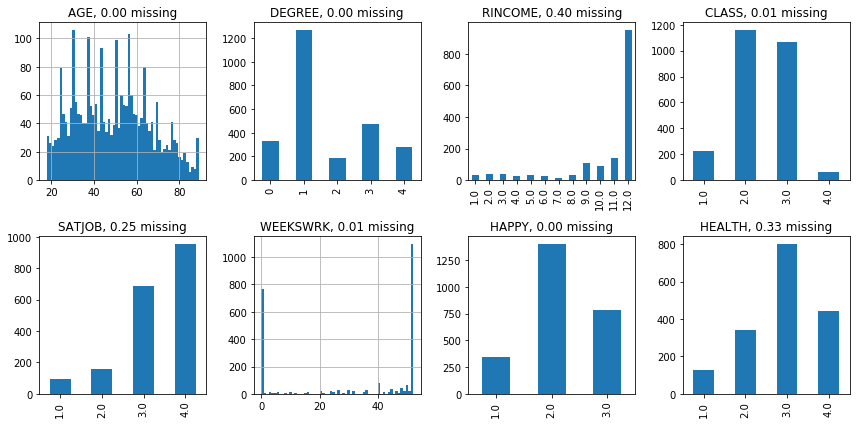

In [5]:
data_gss = load_GSS()
fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i,col in enumerate(data_gss):
    if col in ['AGE', 'WEEKSWRK']:
        data_gss[col].dropna().hist(ax=axes[i//4, i%4], bins=60)
    else:
        to_plot=data_gss[col].dropna().value_counts().sort_index()
        to_plot.plot(kind='bar', ax=axes[i//4, i%4])
    _title = f'{col}, {data_gss[col].isna().mean():.2f} missing'
    axes[i//4, i%4].set_title(_title)
plt.tight_layout()

In [3]:
#fig.savefig('GSS_histogram.pdf', bbox_inches='tight')

We mask $10\%$ of the observed entries uniformly at random as a test set to evaluate our imputations. 

In [6]:
gss_masked = mask_MCAR(X=data_gss, mask_fraction=.1, seed=101)

The Python package has an API consistent with the `sklearn.impute` module. To impute the missing entries in an incomplete dataset, we simply create a model instance and call `fit_transform()` with the default setting. The default choice uses `training_mode='standard'`, which corresponds to the standard EM algorithm in [Zhao & Udell, 2020b]. 

In [5]:
model = GaussianCopula()
Ximp = model.fit_transform(X=gss_masked)

To compare imputation performance across variables with different scales, we use scaled mean absolute error (SMAE) for each variable: the MAE of imputations scaled by the imputation MAE of median imputation.
As shown below, the Gaussian copula imputation improves over median imputation by $10.9\%$ on average.

In [6]:
from GaussianCopulaImp.helper_evaluation import get_smae
smae = get_smae(x_imp=Ximp, x_true=data_gss, x_obs=gss_masked)
print(f'SMAE average over all variables: {smae.mean():.3f}')

SMAE average over all variables: 0.891


We can also extract the copula correlation estimates to see which variables are correlated, as shown below.

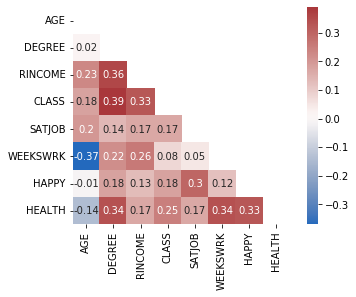

In [7]:
copula_corr_est = model.get_params()['copula_corr']
mask = np.zeros_like(copula_corr_est)
mask[np.triu_indices_from(mask)] = True
names = data_gss.columns
fig = sns.heatmap(np.round(copula_corr_est,2), 
                  xticklabels=names, yticklabels=names, 
                  annot=True, mask=mask, square=True, cmap='vlag')

In [51]:
#fig.figure.savefig('GSS_corr.pdf', bbox_inches='tight')

Interestingly, 
`DEGREE` and `CLASS` have the largest positive  correlation $0.39$, 
while `WEEKSWRK` and `AGE` have the largest negative correlation $-0.37$.

In [8]:
np.fill_diagonal(copula_corr_est, 0)
corr_est = pd.DataFrame(copula_corr_est, columns = names, index=names)

def most_correlated(x):
    index = x.abs().idxmax()
    corr = x[index]
    return index, corr

corr_est.apply(most_correlated)

AGE         (WEEKSWRK, -0.3717927038120352)
DEGREE          (CLASS, 0.3913561044161574)
RINCOME        (DEGREE, 0.3568178260843191)
CLASS          (DEGREE, 0.3913561044161574)
SATJOB          (HAPPY, 0.2982571539879448)
WEEKSWRK        (AGE, -0.37179270381203516)
HAPPY          (HEALTH, 0.3347964974483138)
HEALTH         (DEGREE, 0.3439822665254431)
dtype: object

### Determine the variable types

**gcimpute** defines five variable types: `continuous`, `ordinal`,
`lower_truncated`, `upper_truncated` and  `twosided_truncated`.
The choice of variable type can have a strong effect on inference and imputation.
**gcimpute** provides good default guesses of data types, which we used 
in the previous call.
After fitting the model, we can query the model to ask which variable type was chosen as shown below. 
Only `AGE` is treated as continuous; all other variables are treated as ordinal. 
No variable is treated as truncated.

In [9]:
for key,value in model.get_vartypes(feature_names = names).items():
    print(f'{key}: {value}')

continuous: ['AGE']
ordinal: ['DEGREE', 'RINCOME', 'CLASS', 'SATJOB', 'WEEKSWRK', 'HAPPY', 'HEALTH']
lower_truncated: []
upper_truncated: []
twosided_truncated: []


We can specify the type of each variable 
in `model.fit_transform()` directly.
Otherwise, the default setting works well. 
It guesses the variable type based on the frequency of observed unique values.
A variable is treated as continuous if its mode's frequency is less than $0.1$.
A variable is treated as lower/upper/two sided truncated if its minimum's/maximum's/minimum's and maximum's frequency is more than  $0.1$ and the distribution, excluding these values, is continuous by the previous rule. 
All other variables are ordinal.
The default threshold value $0.1$  works well in general, but can be changed using the parameter `min_ord_ratio` in the model call `GaussianCopula()`.
For example, 
let us look at the frequency of the min, max, and mode for each GSS variable.

In [10]:
def key_freq(col):
    freq = col.value_counts(normalize=True)
    key_freq = {'mode':freq.max()}
    _min, _max = col.min(), col.max()
    key_freq['min'] = freq[_min]
    key_freq['max'] = freq[_max]
    freq_middle = freq.drop(index = [_min, _max])
    key_freq['mode_nominmax'] = freq_middle.max()/freq_middle.sum()
    return pd.Series(key_freq).round(2)
table = data_gss.apply(lambda x: key_freq(x.dropna())).T
print(tabulate(table, headers='keys', tablefmt='psql'))

+----------+--------+-------+-------+-----------------+
|          |   mode |   min |   max |   mode_nominmax |
|----------+--------+-------+-------+-----------------|
| AGE      |   0.02 |  0    |  0.01 |            0.02 |
| DEGREE   |   0.5  |  0.13 |  0.11 |            0.66 |
| RINCOME  |   0.62 |  0.02 |  0.62 |            0.26 |
| CLASS    |   0.46 |  0.09 |  0.03 |            0.52 |
| SATJOB   |   0.5  |  0.05 |  0.5  |            0.81 |
| WEEKSWRK |   0.44 |  0.31 |  0.44 |            0.13 |
| HAPPY    |   0.55 |  0.13 |  0.31 |            1    |
| HEALTH   |   0.47 |  0.07 |  0.26 |            0.7  |
+----------+--------+-------+-------+-----------------+


Only `AGE` has mode frequency below $0.1$ and thus is treated as continuous. 
All other variables have strong concentration on a single value,
even after removing the min and max, so these are treated as ordinal.
`WEEKSWRK` is an interesting example.
It has 53 levels, yet 75\% of the population works either 0 or 52 weeks per year: 
thus it is not treated as a continuous variable.
Interestingly, if we insist that `WEEKWRK` be treated as continuous, the algorithm diverges! We discuss this phenomenon in the trouble shooting notebook https://github.com/udellgroup/GaussianCopulaImp/blob/master/Examples/Trouble_shooting.ipynb.

### Monitoring the algorithm fitting

**gcimpute** considers the model to have converged when the model parameters no longer change rapidly:
It terminates when ${||\Sigma^{t+1}-\Sigma^{t}||_F}/{||\Sigma^{t}||_F}$ falls below the specified \code{tol}, where $\Sigma^t$ is the model parameter estimate at the $t$-th iteration and $||\cdot||_F$ denotes the Frobenius norm. 
In practice, 
the default value `tol=0.01` works well and the algorithm  converges in less than 30 iterations in most cases.


Tracking the objective value may also be useful.
The objective value is the marginal likelihood at the observed locations, averaged over all instances. 
When all variables are continuous, 
**gcimpute**computes the exact likelihood.
In other cases, 
\gcpackage computes an approximation to the likelihood.
The approximation behaves well in most cases including those with all ordinal variables: 
it monotonically increases during the fitting process and finally converges.

To monitor the parameter update and the objective during fitting, simply set `verbose=1` in the model call.

In [12]:
model = GaussianCopula(verbose=1)
Ximp = model.fit_transform(X=gss_masked)

Iteration 1: copula parameter change 0.1168, likelihood -9.6913
Iteration 2: copula parameter change 0.0644, likelihood -9.5869
Iteration 3: copula parameter change 0.0366, likelihood -9.5278
Iteration 4: copula parameter change 0.0220, likelihood -9.4942
Iteration 5: copula parameter change 0.0140, likelihood -9.4744
Iteration 6: copula parameter change 0.0093, likelihood -9.4623
Convergence achieved at iteration 6


Using a tolerance `tol` that is too small can require many more iterations and can cause overfitting.
Hence users may wish to tune `tol` for a specific dataset for best performance
using `fit_transform_evaluate()`.
This function runs the EM algorithm for specified `n_iter` iterations and evaluates the imputed dataset using the provided `eval_func` at each iteration.
The function `eval_func` should take an imputed dataset as input and output the desired evaluation results.
We can design `eval_func`  to evaluate the imputation accuracy or the prediction accuracy of a supervised learning pipeline with the imputed dataset as feature matrix.
For example, to evaluate the mean SMAE of the GSS dataset for up to $15$ iterations, we can run the following code:

In [13]:
m = GaussianCopula(verbose=1)
get_err = lambda x: get_smae(x, x_true=data_gss, x_obs=gss_masked).mean()
r = m.fit_transform_evaluate(X=gss_masked, eval_func=get_err, num_iter=15)

Iteration 1: copula parameter change 0.1168, likelihood -9.6913
Iteration 2: copula parameter change 0.0644, likelihood -9.5869
Iteration 3: copula parameter change 0.0366, likelihood -9.5278
Iteration 4: copula parameter change 0.0220, likelihood -9.4942
Iteration 5: copula parameter change 0.0140, likelihood -9.4744
Iteration 6: copula parameter change 0.0093, likelihood -9.4623
Iteration 7: copula parameter change 0.0063, likelihood -9.4545
Iteration 8: copula parameter change 0.0044, likelihood -9.4494
Iteration 9: copula parameter change 0.0032, likelihood -9.4460
Iteration 10: copula parameter change 0.0023, likelihood -9.4437
Iteration 11: copula parameter change 0.0017, likelihood -9.4421
Iteration 12: copula parameter change 0.0012, likelihood -9.4409
Iteration 13: copula parameter change 0.0009, likelihood -9.4401
Iteration 14: copula parameter change 0.0007, likelihood -9.4396
Iteration 15: copula parameter change 0.0005, likelihood -9.4392


Text(0, 0.5, 'SMAE')

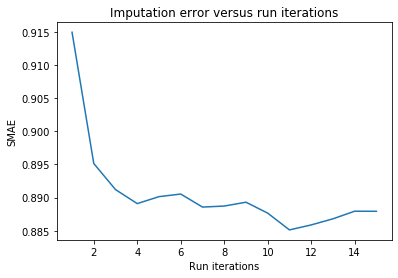

In [14]:
plt.plot(list(range(1, 16, 1)), r['evaluation'])
plt.title('Imputation error versus run iterations')
plt.xlabel("Run iterations")
plt.ylabel("SMAE")
#plt.savefig('GSS_imp_error.pdf', bbox_inches='tight')

As shown above, the imputation error fluctuates in a small range from $0.885$ to $0.890$ after four iterations.
The default parameter setting stops at iteration $6$.

## Acceleration through parallelism, minibatch training, and low rank structure

**gcimpute** runs quickly on large datasets by exploiting parallelism, mini-batch training and low rank structure to speed up inference.
Our EM algorithm parallelizes easily: the most expensive computation, the E-step, 
is computed as a sum over samples and thus can be easily distributed over multiple cores. 

To use parallelism with $m$ cores, we simply set `n_jobs=m` in the model call `GaussianCopula()`.
To use mini-batching training, we set `training_mode='minibatch-offline'` also
in the model call `GaussianCopula()`.
The low rank Gaussian copula is invoked using a different model call `LowRankGaussianCopula(rank=k)` with desired rank $k$.
Mini-batch training for the low rank Gaussian copula is more challenging and remains for future work,
as the low rank update is nonlinear. 

### Accelerating datasets with many samples: mini-batch training

Mini-batch training requires choosing a decaying step size $\{\eta_t\}$, a batch size and a maximum number of iterations.
The default setting can be simply invoked by calling `GaussianCopula(training_mode='minibatch-offline')` or explicitly as below:

In [15]:
model_minibatch = GaussianCopula(training_mode='minibatch-offline', 
                                 stepsize_func = lambda t, c=5:c/(c+t),
                                 batch_size = 100,
                                 num_pass = 2
                                )

The step size sequence $\eta_t$ must satisfy $\eta_t \in (0, 1)$ for all $t$ and $\sum_{t=1}^\infty \eta_t^2<\sum_{t=1}^\infty \eta_t=\infty$.
By default, we recommend using $\eta_t = c/(c+t)$ with $c>0$. 
We find it generally suffices to tune $c$ in the range $(0, 10)$.
The default setting $c=5$ works well in many of our experiments. 

Mini-batch training requires a batch size $s\geq p$ to avoid inverting a singular matrix [Zhao et al. 2020]. 
In practice, 
it is easy to select $s\geq p$, since problems with large $p$ should use `LowRankGaussianCopula` instead. 

The maximum number of iterations matters more for mini-batch methods, because the stochastic fluctuation over mini-batches makes it hard to decide convergence based on the parameter update. 
Instead of specifying an exact maximum number of iterations, it may be more convenient to select a desired number of epochs (complete passes through the data), i.e. `max_iter`$=\left \lceil{\frac{n}{s}}\right \rceil  \times $ `num_pass` with $s$ as the mini-batch size. Often using `num_pass`$=2$ (the default setting) or $3$ gives satisfying results.

We now run min-batch training with the defaults on the GSS dataset:

In [16]:
t1=time.time()
model_minibatch = GaussianCopula(training_mode='minibatch-offline')
Ximp_batch = model_minibatch.fit_transform(X=gss_masked)
t2=time.time()
print(f'Runtime: {t2-t1:.2f} seconds')
smae_batch = get_smae(x_imp=Ximp_batch, x_true=data_gss, x_obs=gss_masked)
print(f'Imputation error: {smae_batch.mean():.3f}')

Runtime: 15.27 seconds
Imputation error: 0.886


Let us also re-run and record the runtime of the standard training mode:

In [17]:
t1=time.time()
GaussianCopula().fit_transform(X=gss_masked)
t2=time.time()
print(f'Runtime: {t2-t1:.2f} seconds')

Runtime: 39.47 seconds


Mini-batch training not only reduces runtime by $64\%$ but also improves the imputation error (from $0.891$ to $0.886$)! 

### Accelerating datasets with many variables: low rank structure

The low rank Gaussian copula (LRGC) model accelerates convergence by decreasing the number of 
model parameters. Here we showcase its performance on a subset of the MovieLens1M dataset: 
the $150$ movies with the most ratings and users who rates at least $20$ of these movies. 
That yields a dataset consisting of $4045$ users and $150$ movies with $36.4\%$ of ratings observed.
We further mask $10\%$ entries for evaluation. 

In [7]:
data_movie = load_movielens1m(num=400, min_obs=150, verbose=True)
movie_masked = mask_MCAR(X=data_movie, mask_fraction=0.1, seed=101)

The loaded dataset consists of 914 users and 400 movies with 53.3% ratings observed


We run `GaussianCopula()` as well as `LowRankGaussianCopula(rank=10)`. Here our goal is not to choose the optimal rank, but rather show the runtime comparison between two models. 

In [9]:
a = time.time()
model_movie_lrgc = LowRankGaussianCopula(rank=10, verbose=1)
m_imp_lrgc = model_movie_lrgc.fit_transform(X=movie_masked)
print(f'LRGC runtime {(time.time()-a)/60:.2f} mins.')
a = time.time()
model_movie_gc = GaussianCopula(verbose=1)
m_imp_gc = model_movie_gc.fit_transform(X=movie_masked)
print(f'GC runtime {(time.time()-a)/60:.2f} mins.')

Interation 1: noise ratio 0.6615, copula parameter change 0.1228, likelihood -413.1551
Interation 2: noise ratio 0.6486, copula parameter change 0.0535, likelihood -411.8463
Interation 3: noise ratio 0.6391, copula parameter change 0.0310, likelihood -411.0099
Interation 4: noise ratio 0.6319, copula parameter change 0.0207, likelihood -410.3363
Interation 5: noise ratio 0.6265, copula parameter change 0.0150, likelihood -409.8006
Interation 6: noise ratio 0.6223, copula parameter change 0.0115, likelihood -409.3799
Interation 7: noise ratio 0.6191, copula parameter change 0.0091, likelihood -409.0508
Convergence achieved at iteration 7
LRGC runtime 8.61 mins.
Iteration 1: copula parameter change 0.3884, likelihood -403.1948
Iteration 2: copula parameter change 0.1425, likelihood -391.8407
Iteration 3: copula parameter change 0.0699, likelihood -384.8827
Iteration 4: copula parameter change 0.0420, likelihood -379.6849
Iteration 5: copula parameter change 0.0290, likelihood -375.6907
I

Here we already see that LRGC already reduces the runtime by $34\%$ compared to the standard Gaussian copula,
although the number of variables $p=400$ is not particularly large.
When the number of variables is much larger,
the acceleration is also more significant.
Moreover, LRGC improves the imputation error from $0.616$ to $0.583$, as shown below.
On a rating scale 1--5 stars, the errors (about .5 stars) are quite small.

In [11]:
mae_gc = get_mae(x_imp=m_imp_gc, x_true=data_movie, x_obs=movie_masked)
mae_lrgc = get_mae(x_imp=m_imp_lrgc, x_true=data_movie, x_obs=movie_masked)
print(f'LRGC imputation MAE: {mae_lrgc:.3f}')
print(f'GC imputation MAE: {mae_gc:.3f}')

LRGC imputation MAE: 0.583
GC imputation MAE: 0.616


## Imputation for streaming datasets

**gcimpute**'s `minibatch-online` training mode performs streaming imputation:
as new samples arrive, it imputes the missing data immediately and then updates the model parameters.
We showcase its performance on eight daily recorded economic time series variables from federal reserve bank of St. Louis (FRED), consisting of 3109 days from 2008-06-03 to 2020-12-31. The selected eight variables are diverse and among the most popular economic variables in FRED: gold volatility index, stock volatility index, bond spread, dollar index, inflation rate, interest rate, crude oil price, and US dollar to Euro rate,
shown below.

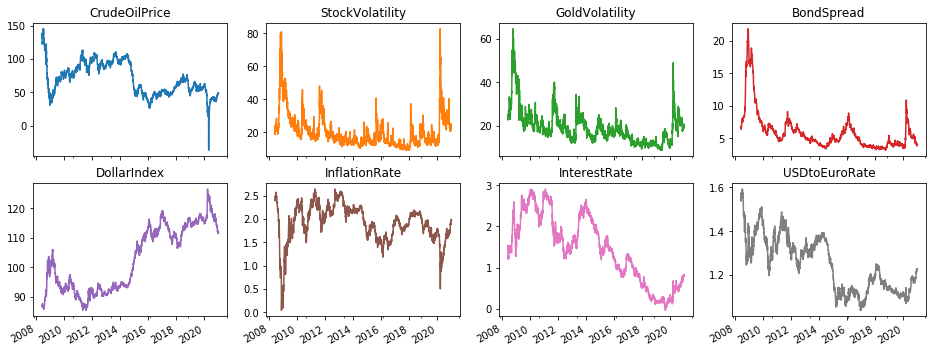

In [5]:
fred_data = load_FRED()
fred_data.plot(subplots = True, layout = (2,4), figsize = (16, 6),
               legend = False, title = fred_data.columns.to_list()
               )
pass

Here we consider a scenario in which some variables are observed as soon as they are generated, while others are observed after a lag of one day. 
The goal is to predict the unobserved variables each day. 
We use stock `StockVolatility` and `CrudeOilPrice` as two unobserved variables. 
Each day,
using a fitted Gaussian copula model, 
we predict their values based on both their historical values (through the marginal) and the six other observed variables at that day (through the copula correlation).
After we make our prediction, the actual values are revealed and used to update the Gaussian copula model.
**gcimpute** conveniently supports this task.
Let us first create a Gaussian copula model to impute streaming datasets (`training_mode='minibatch-online'`), shown as below.

In [6]:
model = GaussianCopula(training_mode='minibatch-online', 
                       window_size=10,
                       const_stepsize=0.1, 
                       batch_size=10, 
                       decay=0.01
                      )

Three hyperparameters control the learning rate of the model:
`window_size` controls the number of recent observations used for marginal estimation;
`const_stepsize` controls the size of the copula correlation update;
and `batch_size` is the frequency of the copula correlation update.
In contrast, `decay` only controls the imputation and does not influence the model update.
Smaller values of `decay` put less weight on old observations, i.e., forget stale data faster.
In economic time series, yesterday's observation often predicts today's value well.
We use a small value `decay=.01`, so that the imputation depends most strong on yesterday's observation, but interpolates all values in the window.
These parameters can be tuned for best performance.

Next, to conduct the experiment described above, 
we prepare two data matrices with one row for each temporal observation: 
`X` for imputing missing entries 
and `X_true` for updating the model.
We use first $25$ rows to initialize the model.

In [7]:
fred_masked = fred_data.assign(StockVolatility=np.nan, CrudeOilPrice=np.nan)
Ximp = model.fit_transform(X=fred_masked, X_true=fred_data, n_train=25)

More concretely,
a Gaussian copula model receives the $t$-th row of `X`, 
imputes its missing entries, 
and then is asked to update parameters of the model using the $t$-th row of `X_true`.
`X_true` must agree with `X` at all observed entries in `X`, but may 
reveal additional entries that are missing in `X`.
By default, `X_true=None`, indicating no additional entries beyond `X` are available.
In this example, two columns of `fred_masked` are missing: `StockVolatility` and `CrudeOilPrice`. All other columns fully observed.
`fred_data` has all columns fully observed.

We now evaluate the imputation performance and compare against a simple but powerful alternative, yesterday's observation.
The predicted series of both methods are almost visually indistinguishable from the true values, but the Gaussian copula predictions perform better on average,
with lower mean squared error (MSE).

In [8]:
n_train = 25
for i, col in enumerate(['CrudeOilPrice', 'StockVolatility']):
    _true = fred_data[col][n_train:].to_numpy()
    _err_yes = fred_data[col][n_train-1:-1].to_numpy() - _true
    _err_GC = Ximp[n_train:,i] - _true
    print(f'For {col}:')
    print(f'Gaussian Copula Pred MSE: {np.power(_err_GC,2).mean():.3f}')
    print(f'Yesterday Value Pred MSE: {np.power(_err_yes,2).mean():.3f}')

For CrudeOilPrice:
Gaussian Copula Pred MSE: 3.672
Yesterday Value Pred MSE: 4.313
For StockVolatility:
Gaussian Copula Pred MSE: 3.998
Yesterday Value Pred MSE: 4.368


## Imputation uncertainty

So far we have seen several methods to impute missing data.
**gcimpute** also provides functionality to quantify the uncertainty of the imputations:
multiple imputation,
confidence interval for a single imputation,
and relative reliability for a single imputation.
We present the first two notions here, since they are widely used.  The third, relative reliability, aims to rank the imputation quality among all imputed entries [Zhao & Udell, 2020a]. 
It is well suited for the top-k recommendation task in collaborative filtering.

### Multiple imputation
Multiple imputation creates several imputed copies of the original dataset, each having potentially different imputed values. The uncertainty due to imputations can be propagated into subsequent analyses by analyzing each imputed dataset. 
Multiple imputation is commonly used in supervised learning when features may have missing entries:
a researcher creates multiple imputed feature datasets, then trains a model with each imputed training feature dataset and predicts with each imputed test feature vector. 
Finally, they pool all predictions into a single prediction, for example, using the mean or majority vote. 
An ensemble model like this often outperforms a single model trained from a single imputation.

We  how to use multiple imputation in **gcimpute** on a regression task from UCI datasets, the white wine quality dataset. This dataset has 11 continuous features and a rating target for 4898 samples. The (transposed) header of the dataset is shown below.

In [3]:
data_wine = load_whitewine()
print(tabulate(data_wine.head().T,  tablefmt='psql'))

+----------------------+---------+---------+---------+----------+----------+
| fixed acidity        |   7     |   6.3   |  8.1    |   7.2    |   7.2    |
| volatile acidity     |   0.27  |   0.3   |  0.28   |   0.23   |   0.23   |
| citric acid          |   0.36  |   0.34  |  0.4    |   0.32   |   0.32   |
| residual sugar       |  20.7   |   1.6   |  6.9    |   8.5    |   8.5    |
| chlorides            |   0.045 |   0.049 |  0.05   |   0.058  |   0.058  |
| free sulfur dioxide  |  45     |  14     | 30      |  47      |  47      |
| total sulfur dioxide | 170     | 132     | 97      | 186      | 186      |
| density              |   1.001 |   0.994 |  0.9951 |   0.9956 |   0.9956 |
| pH                   |   3     |   3.3   |  3.26   |   3.19   |   3.19   |
| sulphates            |   0.45  |   0.49  |  0.44   |   0.4    |   0.4    |
| alcohol              |   8.8   |   9.5   | 10.1    |   9.9    |   9.9    |
| quality              |   6     |   6     |  6      |   6      |   6      |

We now randomly mask $30\%$ entries as missing among all features and fit a Gaussian copula model to the masked dataset.

In [4]:
X_wine = data_wine.to_numpy()[:,:-1]
X_wine_masked = mask_MCAR(X_wine, mask_fraction=0.3)
model_wine = GaussianCopula()
X_wine_imputed = model_wine.fit_transform(X=X_wine_masked)

Now we use the first 4000 instances as a training dataset and the remaining 898 instances as test dataset. Since the goal is to show how to use multiple imputation, 
we use simple linear model as the prediction model. 
Now, let us first examine the mean squared error (MSE) of the linear model fitted on the complete feature dataset.

In [5]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression as LR
X_train, X_test = X_wine[:4000], X_wine[4000:]
y_train, y_test = data_wine['quality'][:4000], data_wine['quality'][4000:]
y_pred = LR().fit(X=X_train, y=y_train).predict(X=X_test)
np.round(MSE(y_test, y_pred),4)

0.5121

Now let us examine the MSE of the linear model fitted on the single imputed dataset.

In [6]:
X_train_imp, X_test_imp = X_wine_imputed[:4000], X_wine_imputed[4000:]
y_pred_imp = LR().fit(X=X_train_imp, y=y_train).predict(X=X_test_imp)
np.round(MSE(y_test, y_pred_imp),4)

0.5295

Not surprisingly, replacing $30\%$ feature values with the corresponding imputation does hurt the prediction accuracy. Now let us draw $5$ imputed datasets, train a linear model and get prediction for each imputed dataset, and derive the final prediction as the average across 5 different prediction. As shown below, the mean-pooled prediction improves the results from single imputation and performs very close to the results using the complete dataset.

In [7]:
X_wine_imputed_mul = model_wine.sample_imputation(X=X_wine_masked, num=5)
y_pred_mul_imputed = []
for i in range(5):
    X_imputed = X_wine_imputed_mul[...,i]
    X_train_imputed, X_test_imputed = X_imputed[:4000], X_imputed[4000:]
    y_pred_imputed = LR().fit(X=X_train_imputed, y=y_train).predict(X=X_test_imputed)
    y_pred_mul_imputed.append(y_pred_imputed)
y_pred_mul_imputed = np.array(y_pred_mul_imputed).mean(axis=0)
np.round(MSE(y_test, y_pred_mul_imputed), 4)

0.5152

### Imputation confidence intervals

Confidence intervals (CI) are another important measure of uncertainty.
**gcimpute** can return a CI for each imputed value: 
for example, a 95\% CI should contain the true missing data with probability 95\%. 
In general, these CI are not symmetric around the imputed value
due to the nonlinear transformation .
We will continue to use the white wine dataset to illustration.
After fitting the Gaussian copula model, we can obtain the imputation CI as shown below.

In [15]:
ct = model_wine.get_imputed_confidence_interval()
upper, lower = ct['upper'], ct['lower']

By default, the method `get_imputed_confidence_interval()` extracts the imputation CI of the data used to fit the Gaussian copula model, with significance level `alpha=0.05`.
The empirical coverage of the returned CI is $0.943$, as shown below. 
Hence we see the constructed CI are well calibrated on this dataset.

In [17]:
missing = np.isnan(X_wine_masked)
X_missing = X_wine[missing]
cover = (lower[missing] < X_wine[missing]) & (upper[missing] > X_wine[missing])
np.round(cover.mean(),3)

0.943

The default setting uses an analytic expression to obtain the CI. 
When some variables are not continuous,
a safer approach builds CI using empirical quantiles computed from multiple imputed values.
The resulting CI match when all variables are continuous.
Let us now construct the quantile CI and compare them with the analytical counterparts.
As shown below, the quantile CI has almost the same empirical coverage rate as the analytical CI, validating that the CI are well calibrated.

In [18]:
ct_q = model_wine.get_imputed_confidence_interval(type='quantile')
upper_q, lower_q = ct_q['upper'], ct_q['lower']
cover_q = (lower_q[missing]<X_missing) & (upper_q[missing]>X_missing)
np.round(cover_q.mean(),3)

0.942